# case study group 23

> You are an employee of a fictitious company “106”, which sells gearshift systems to car manufacturers. In order to improve the product of the automatic gearshift system “K3AG1”, your company plans to analyze the damage cases of the last years. The automatic gearshift “K3AG1” is a standard component of the car brand “OEM1” and can be selected by the customer as an equipment feature of the car types “Type11” or “Type12”. From the management of your department you get the task to analyze the production data and parts lists of the customer and your suppliers. Key performance indicators such as service life, mileage, failure rates and usage data are of great importance.

## 1. Importing the data

In [33]:
import os
from typing import List
import pandas as pd
import numpy as np
def read_csv_auto(path: str) -> pd.DataFrame:
    """Read CSV with automatic delimiter detection and robust date parsing off (we'll parse later)."""
    df = pd.read_csv(path, sep=None, engine="python", dtype=str)
    # Drop typical unnamed index columns, if any
    df = df.loc[:, ~df.columns.str.contains(r"^Unnamed", case=False)]
    # Strip quotes/spaces from column names
    df.columns = df.columns.str.strip().str.replace('"', '', regex=False)
    # Strip surrounding quotes/spaces from string cells
    for col in df.select_dtypes(include=["object"]).columns:
        df[col] = df[col].map(lambda x: x.strip().strip('"') if isinstance(x, str) else x)
    return df

# Vehicles (baseline)
path_typ11 = "data/Fahrzeug/Fahrzeuge_OEM1_Typ11.csv"
path_typ12 = "data/Fahrzeug/Fahrzeuge_OEM1_Typ12.csv"

# Registrations
# path_reg   = "source/Zulassungen/Zulassungen_alle_Fahrzeuge.csv"

# Parts per vehicle
path_parts11 = "data/Fahrzeug/Bestandteile_Fahrzeuge_OEM1_Typ11.csv"
path_parts12 = "data/Fahrzeug/Bestandteile_Fahrzeuge_OEM1_Typ12.csv"

# Component (K3AG1)
path_k3ag1   = "data/Komponente/Komponente_K3AG1.csv"
# path_k3AG1_parts = "Bestandteile_Komponente_K3AG1.csv"

# Component (K3SG1)
path_k3sg1 = "data/Komponente/Komponente_K3SG1.csv"

df_typ11  = read_csv_auto(path_typ11)
df_typ12  = read_csv_auto(path_typ12)
# df_reg    = read_csv_auto(path_reg)
df_parts11 = read_csv_auto(path_parts11)
df_parts12 = read_csv_auto(path_parts12)
df_k3ag1  = read_csv_auto(path_k3ag1)
df_k3sg1 = read_csv_auto(path_k3sg1)


FileNotFoundError: [Errno 2] No such file or directory: 'data/Fahrzeug/Fahrzeuge_OEM1_Typ11.csv'

## 2. Data preparation

In [35]:
def coalesce_first(df: pd.DataFrame, candidates: List[str], new_name: str) -> pd.DataFrame:
    """
    Create/overwrite df[new_name] with the first existing, non-null column among candidates.
    If none exist, the column is created with NaN.
    """
    values = None
    for c in candidates:
        if c in df.columns:
            values = df[c] if values is None else values.fillna(df[c])
    df[new_name] = values if values is not None else np.nan
    return df

# Vehicles: ensure presence of the vehicle ID column name 'ID_Fahrzeug'
# (Some exports may have it quoted; read_csv_auto already strips quotes.)
if "ID_Fahrzeug" not in df_typ11.columns:
    # Attempt to find a close match; fallback to no-op if absent.
    pass
if "ID_Fahrzeug" not in df_typ12.columns:
    pass

# Tag vehicle type for provenance
if len(df_typ11):
    df_typ11["vehicle_type"] = "Typ11"
if len(df_typ12):
    df_typ12["vehicle_type"] = "Typ12"

# Baseline vehicles: stack, keep all columns; align by column name
df_vehicles_base = pd.concat([df_typ11, df_typ12], ignore_index=True, sort=False)

# Parts: unify the two parts tables and keep the shared columns
# Expected keys include: ID_Karosserie, ID_Schaltung, ID_Sitze, ID_Motor, ID_Fahrzeug
df_parts_all = pd.concat([df_parts11, df_parts12], ignore_index=True, sort=False)

# Registrations: standardize join key name to 'ID_Fahrzeug' and rename to English labels
# Some files name the vehicle ID as 'IDNummer'
# if "IDNummer" in df_reg.columns and "ID_Fahrzeug" not in df_reg.columns:
#     df_reg = df_reg.rename(columns={"IDNummer": "ID_Fahrzeug"})
# df_reg = df_reg.rename(columns={
#     "Gemeinden": "registration_municipality",
#     "Zulassung": "registration_date",
# })

def clean_k3_dataframe(df):
    df = coalesce_first(
        df,
        candidates=["ID_Schaltung", "ID_Schaltung.x", "ID_Schaltung.y"],
        new_name="ID_Schaltung"
    )   
    
    df = coalesce_first(df,
        ["Produktionsdatum", "Produktionsdatum.x", "Produktionsdatum.y"],
        "transmission_production_date"
    )
    df = coalesce_first(df,
        ["Herstellernummer", "Herstellernummer.x", "Herstellernummer.y"],
        "transmission_manufacturer_no"
    )
    df = coalesce_first(df,
        ["Werksnummer", "Werksnummer.x", "Werksnummer.y"],
        "transmission_plant_no"
    )
    df = coalesce_first(df,
        ["Fehlerhaft", "Fehlerhaft.x", "Fehlerhaft.y"],
        "transmission_defective_flag"
    )
    df = coalesce_first(df,
        ["Fehlerhaft_Datum", "Fehlerhaft_Datum.x", "Fehlerhaft_Datum.y"],
        "transmission_defective_date"
    )
    df = coalesce_first(df,
        ["Fehlerhaft_Fahrleistung", "Fehlerhaft_Fahrleistung.x", "Fehlerhaft_Fahrleistung.y"],
        "transmission_defective_mileage"
    )

    # Keep only the columns we standardized plus the join key
    keep_cols_k3 = [
        "ID_Schaltung",
        "transmission_production_date",
        "transmission_manufacturer_no",
        "transmission_plant_no",
        "transmission_defective_flag",
        "transmission_defective_date",
        "transmission_defective_mileage",
    ]

    keep_cols_k3 = [c for c in keep_cols_k3 if c in df.columns]
    df = df[keep_cols_k3].drop_duplicates()


    return df

df_k3 = pd.concat([df_k3ag1, df_k3sg1], axis = 0, ignore_index=True)
df_k3 = clean_k3_dataframe(df_k3)

NameError: name 'df_typ11' is not defined

## 3. Creation of the final dataset

In [37]:
# Merge with parts (by vehicle)
df_merged = df_vehicles_base.merge(
    df_parts_all,
    how="left",
    on="ID_Fahrzeug",
    suffixes=("", "_parts"),
    validate="m:1"
)

# Merge with K3AG1/K3SG1 component (by transmission ID from parts)
df_merged = df_merged.merge(
    df_k3,
    how="left",
    on="ID_Schaltung",
    validate="m:1"
)

rename_map = {
    "ID_Fahrzeug": "vehicle_id",
    "Produktionsdatum": "vehicle_production_date",
    "Herstellernummer": "vehicle_manufacturer_no",
    "Werksnummer": "vehicle_plant_no",
    "Fehlerhaft": "vehicle_defective_flag",
    "Fehlerhaft_Datum": "vehicle_defective_date",
    "Fehlerhaft_Fahrleistung": "vehicle_defective_mileage",
    "ID_Schaltung": "transmission_id"
}

df_merged = df_merged.rename(columns=rename_map)

date_like_cols = [c for c in [
    "registration_date",
    "transmission_production_date",
    "transmission_defective_date",
] if c in df_merged.columns]

for c in date_like_cols:
    try:
        parsed = pd.to_datetime(df_merged[c], errors="coerce")
        # Keep ISO-8601 string for portability
        df_merged[c] = parsed.dt.strftime("%Y-%m-%d")
    except Exception:
        # Leave as-is on any parsing issues
        pass

df_keeps = df_merged[[ 
    'vehicle_id', 
    'vehicle_production_date',
    'transmission_id', 
    'transmission_production_date',  'transmission_defective_flag',
    'transmission_defective_date', 'transmission_defective_mileage']]

# Ensure output directory exists
output_path = "Final_dataset_group_23.csv"

# Write CSV (UTF-8, comma delimiter, English-friendly headers we added remain in English)
df_keeps.to_csv(output_path, index=False, encoding="utf-8")
df_keeps.to_csv(f"{output_path}.gz", index=False, compression="gzip")   # gzip


NameError: name 'df_vehicles_base' is not defined

## 4. Evaluation

Scanning folder: C:\Users\16499\Documents\123
Found a matching file: Final_dataset_group_23.csv
Attempting to read file: C:\Users\16499\Documents\123\Final_dataset_group_23.csv

File successfully read as CSV!
Content Preview (first 5 rows):
----------------------------------------------------------------
  vehicle_id vehicle_production_date     transmission_id  \
0  11-1-11-1              2008-11-18   K3SG1-105-1051-32   
1  11-1-11-2              2008-11-18  K3SG1-105-1051-141   
2  11-1-11-3              2008-11-19  K3SG1-105-1051-106   
3  11-1-11-4              2008-11-19   K3SG1-105-1051-21   
4  11-1-11-5              2008-11-19   K3SG1-105-1051-59   

  transmission_production_date  transmission_defective_flag  \
0                   2008-11-13                            0   
1                   2008-11-13                            0   
2                   2008-11-13                            0   
3                   2008-11-13                            0   
4                 

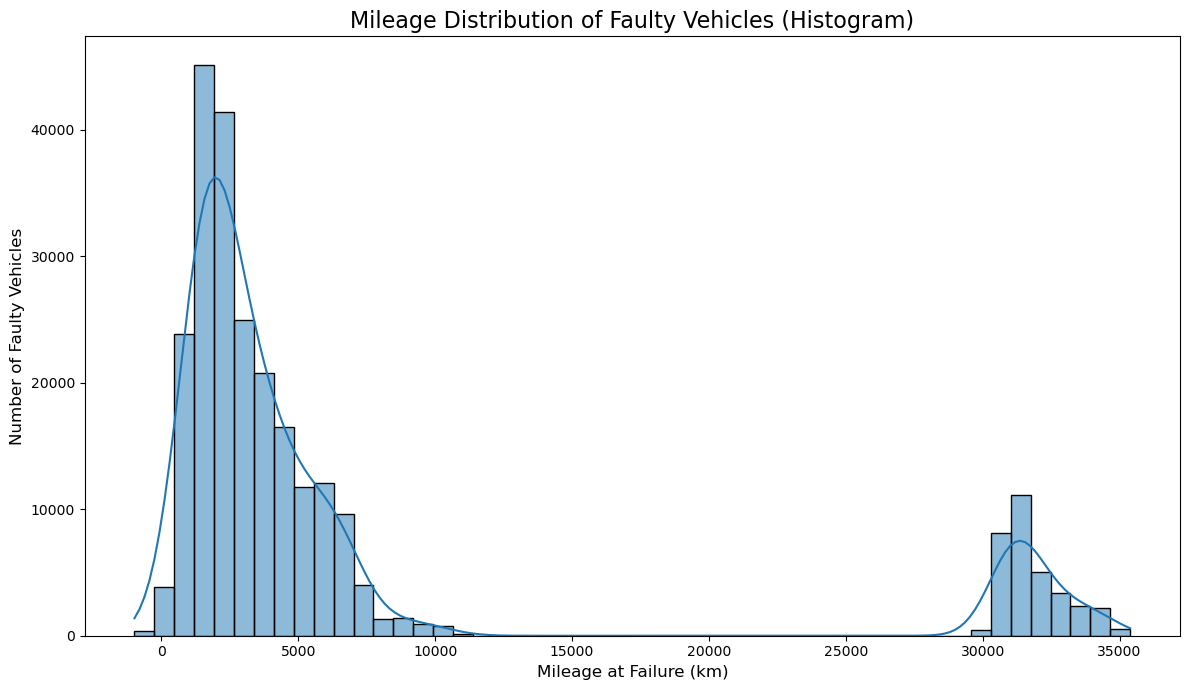


Chart 2 (Box Plot) generated, displaying now.


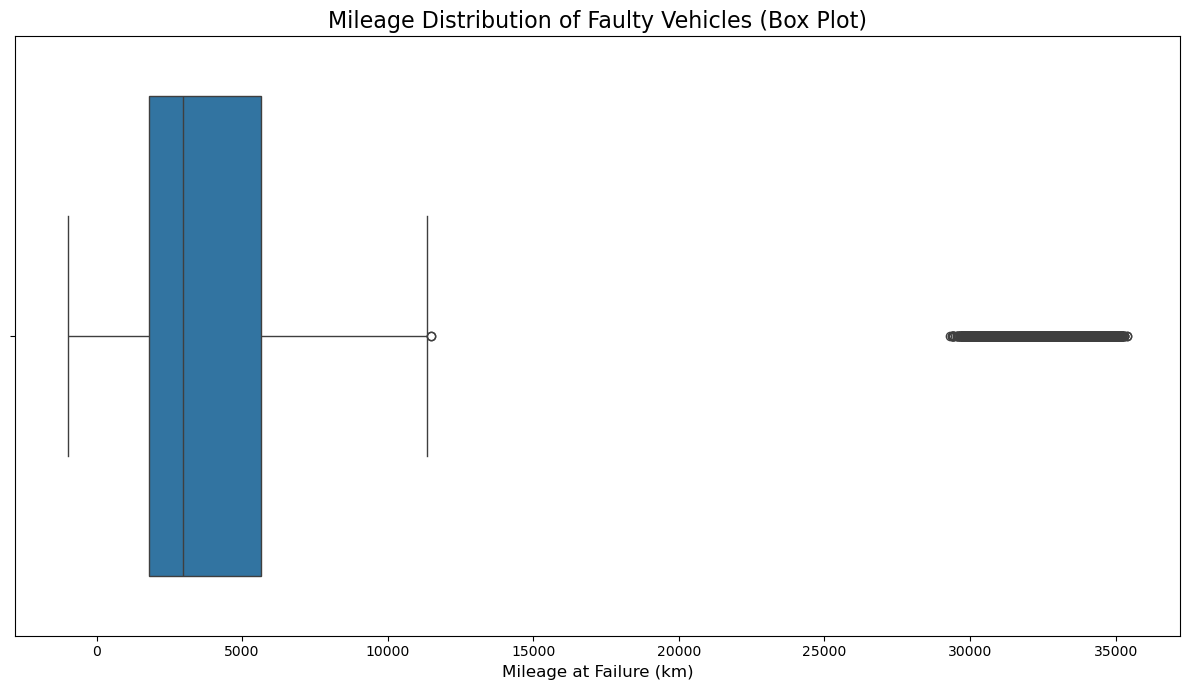


--- Analyzing relationship between 'vehicle_production_date' and fault rate ---

Chart 3 (Fault Rate Trend) generated, displaying now.


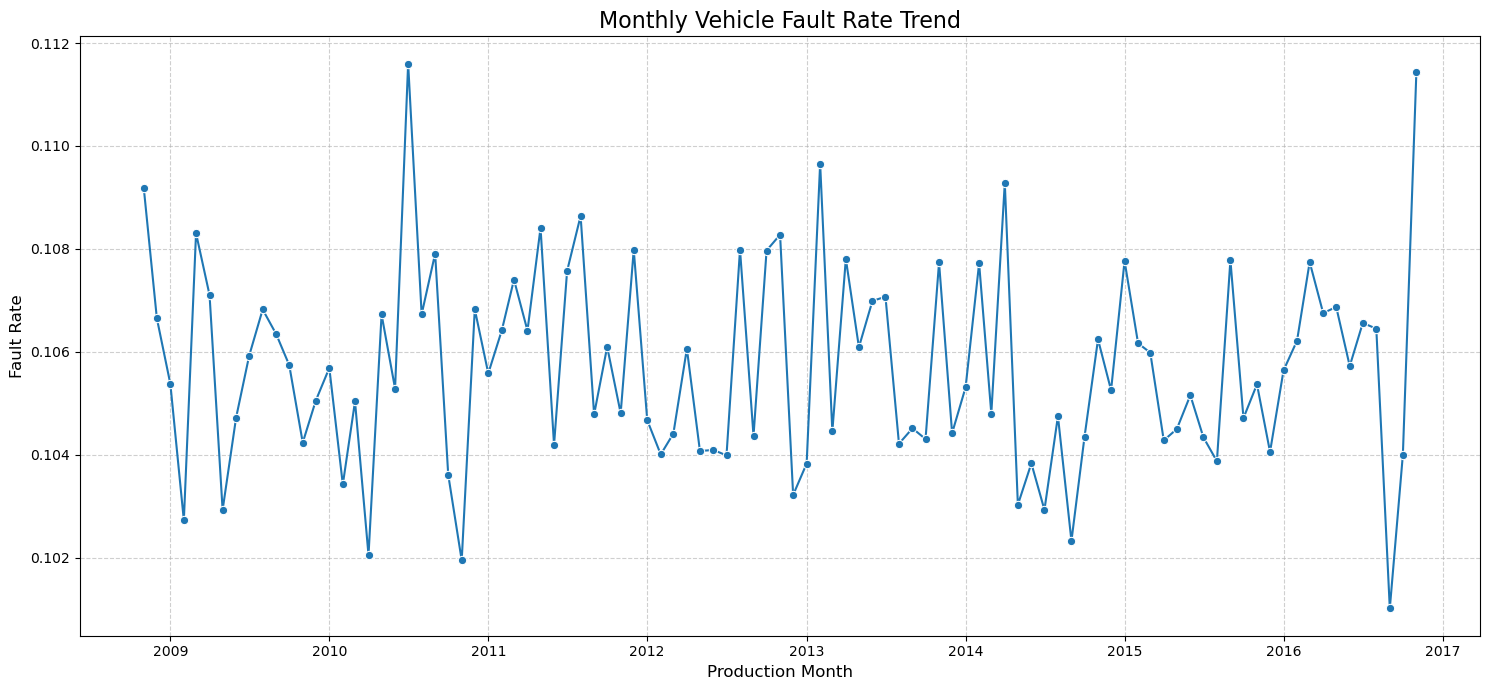


--- Analyzing relationship between Production Season and fault rate ---

Chart 4 (Seasonal Fault Rate) generated, displaying now.


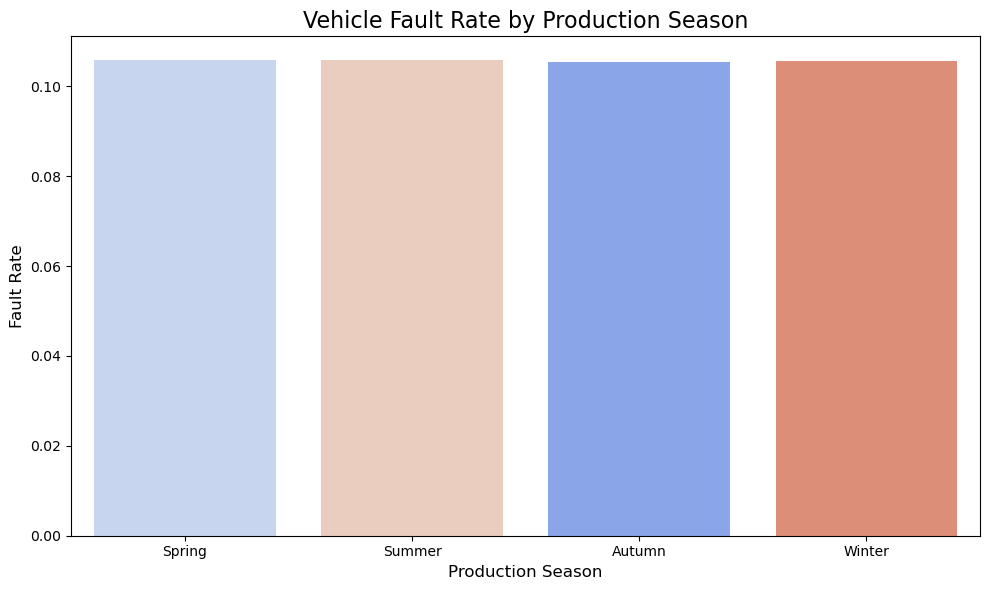


--- Analyzing relationship between 'transmission_id' and fault rate ---

Chart 5 (Top 15 Production Models Fault Rate) generated, displaying now.


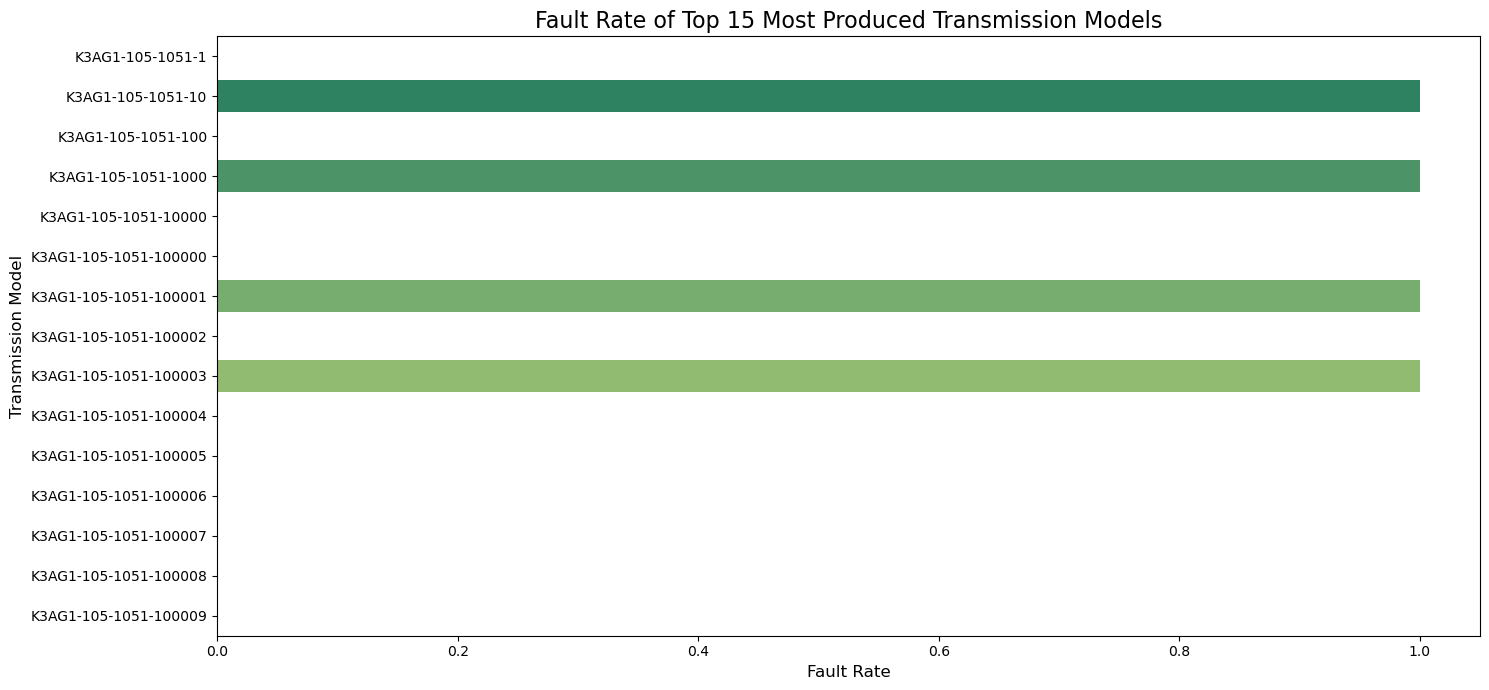


--- Analyzing relationship between Manufacturer and fault rate ---

Chart 7 (Top 2 Manufacturers Fault Rate) generated, displaying now.


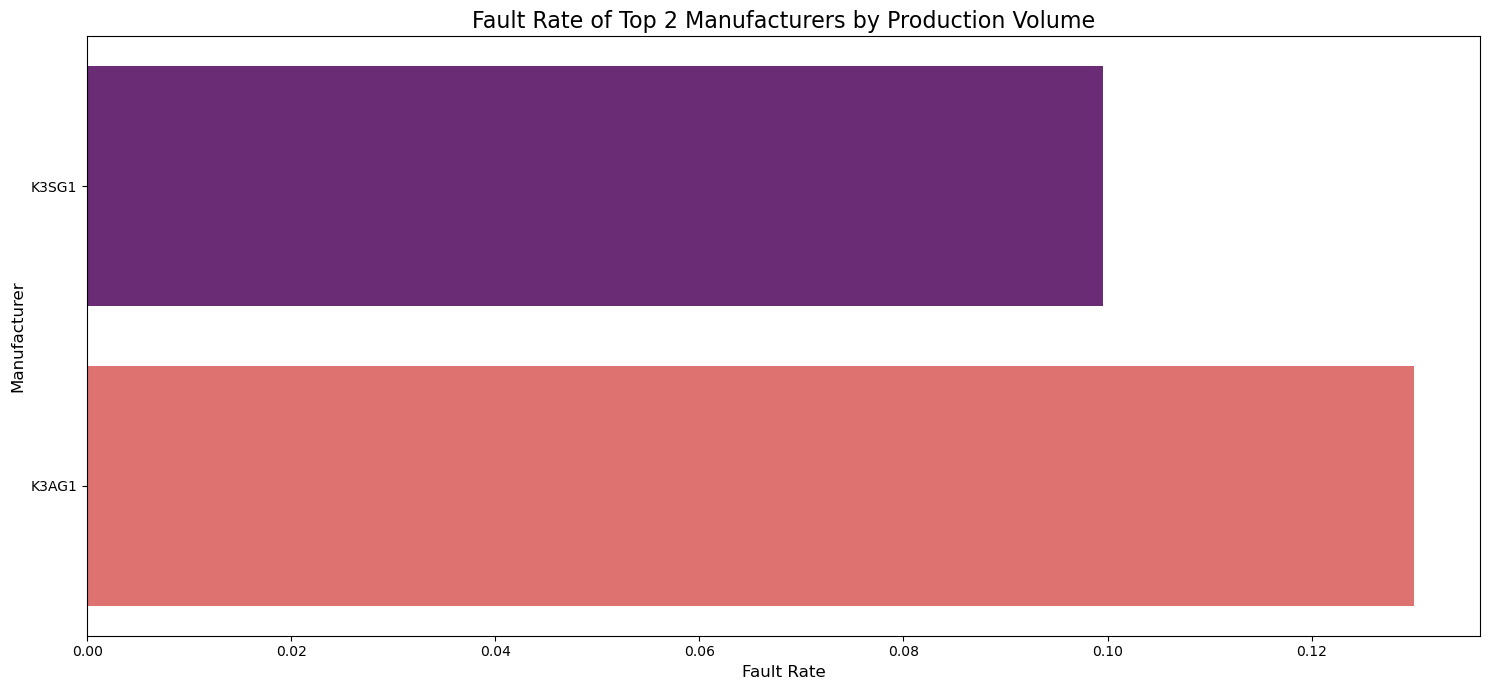


--- Analyzing Time-to-Failure ---

Chart 8 (Time-to-Failure Histogram) generated, displaying now.


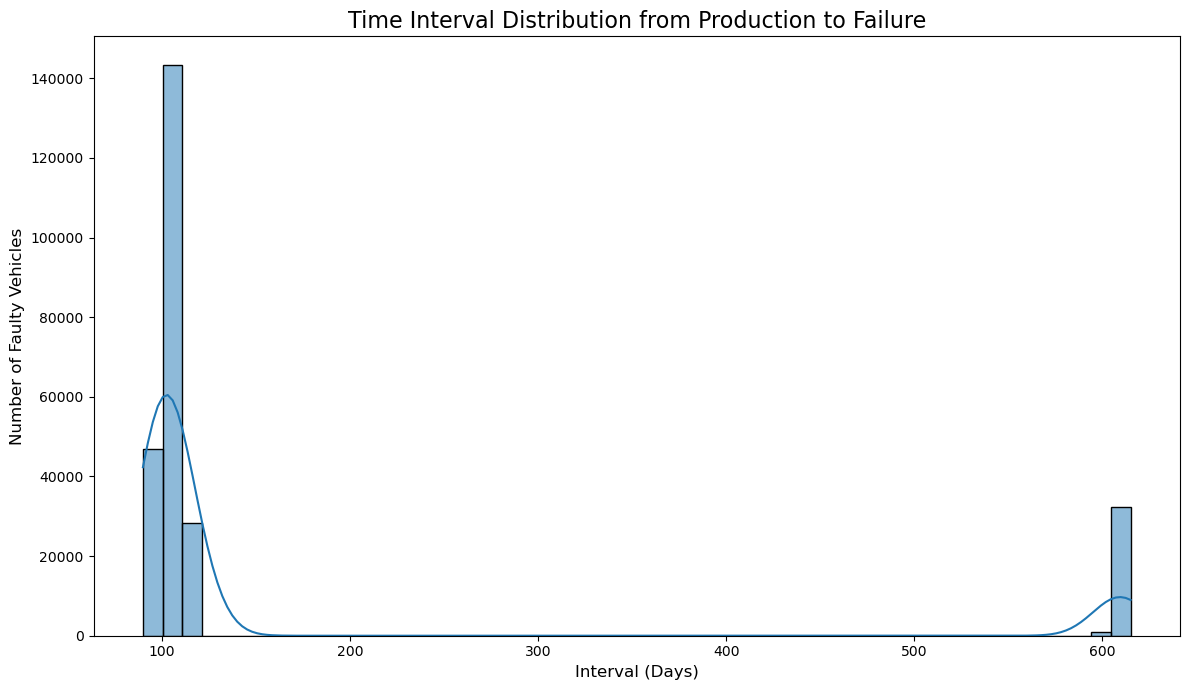


Descriptive statistics for Days to Failure:
count    251994.000000
mean        170.032628
std         171.389833
min          90.000000
25%         101.000000
50%         102.000000
75%         105.000000
max         615.000000
Name: DaysToFailure, dtype: float64

--- Analyzing Production Lead Time vs. Fault ---

Chart 9 (Production Lead Time Box Plot) generated, displaying now.


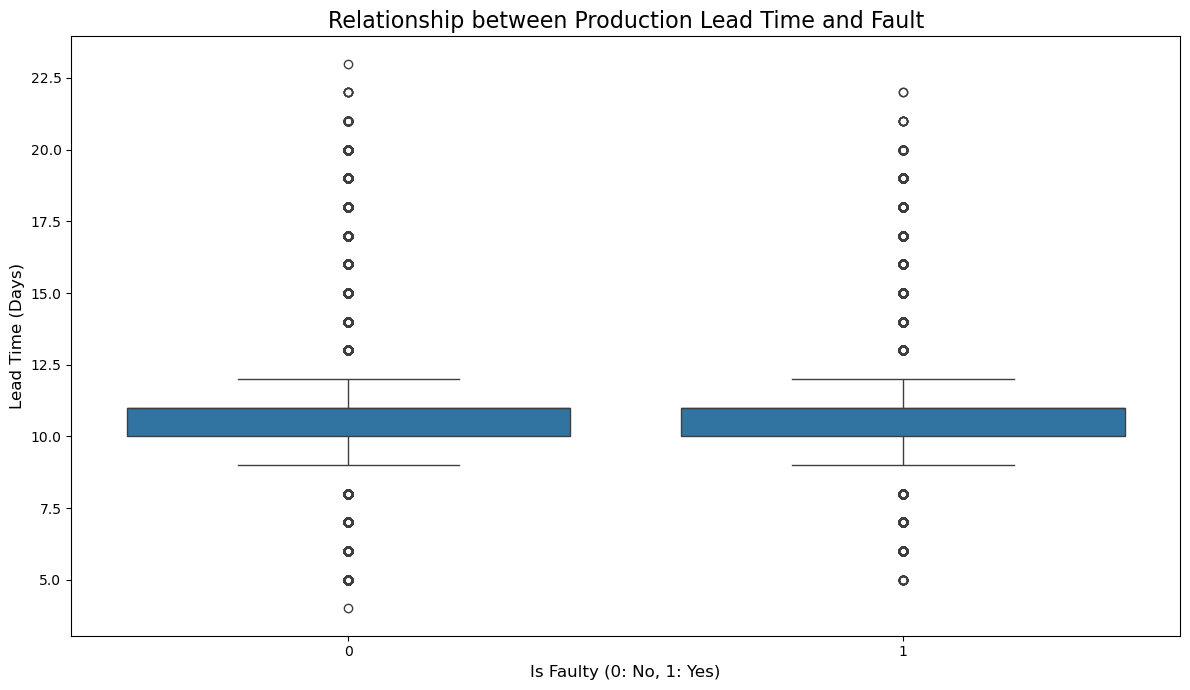


--- Analyzing Fault Heatmap ---

Chart 10 (Fault Heatmap) generated, displaying now.


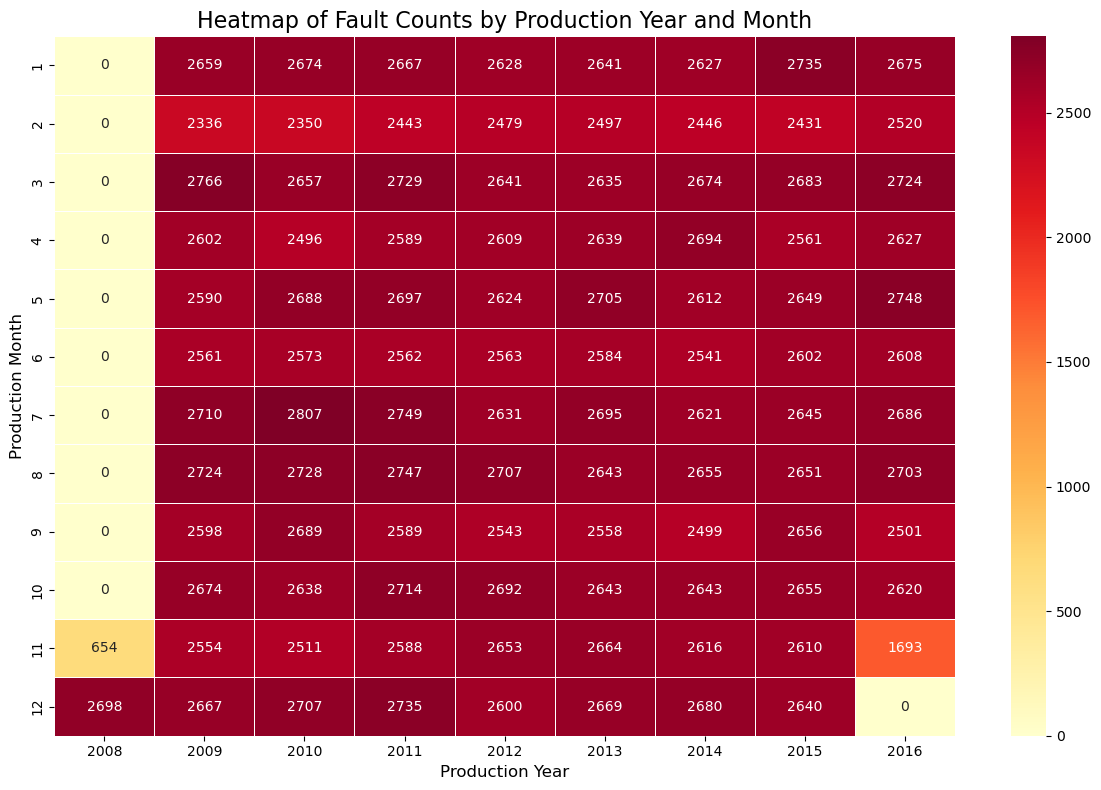


--- Analyzing Variable Correlation ---

Chart 11 (Correlation Heatmap) generated, displaying now.


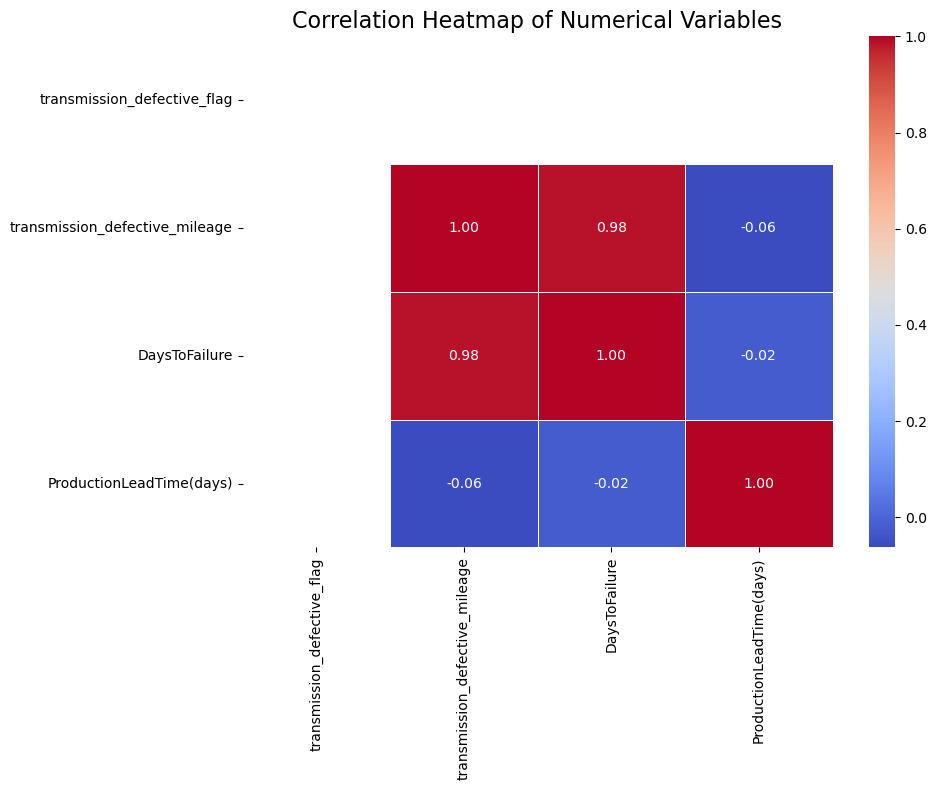


--- Analyzing relationship between Mileage and Time-to-Failure ---

Chart 12 (Scatter Plot with Regression) generated, displaying now.


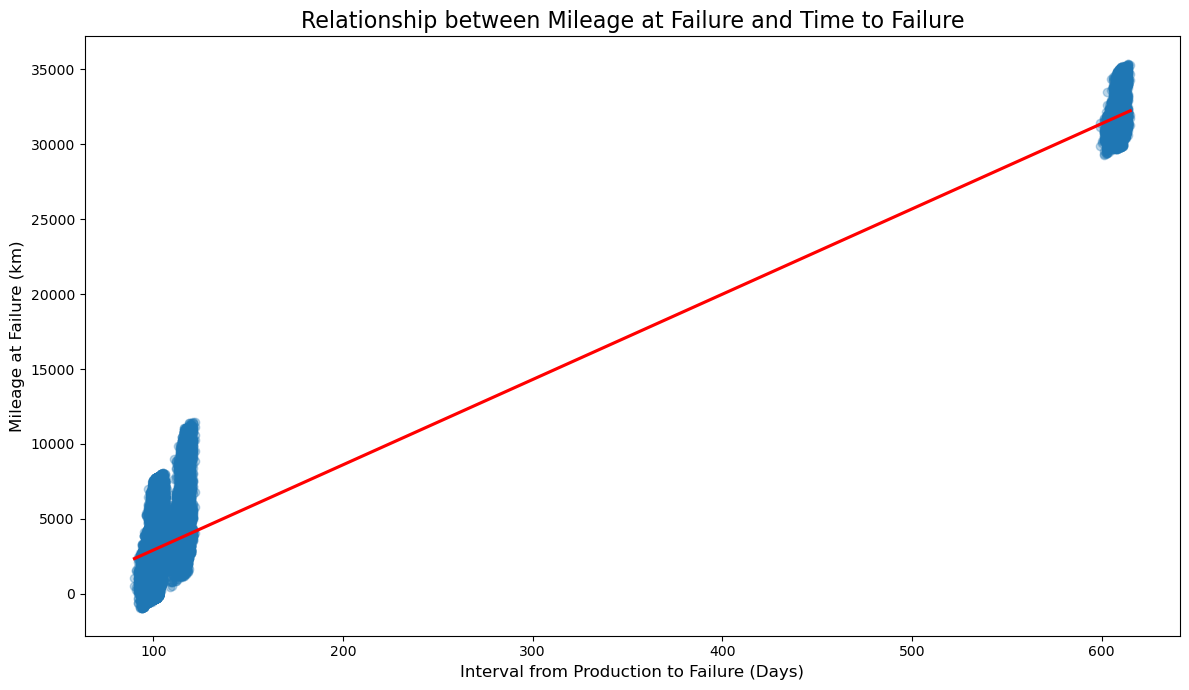


--- Analyzing relationship between Vehicle Type and fault rate ---

Chart 13 (Fault Rate by Top 3 Vehicle Types) generated, displaying now.


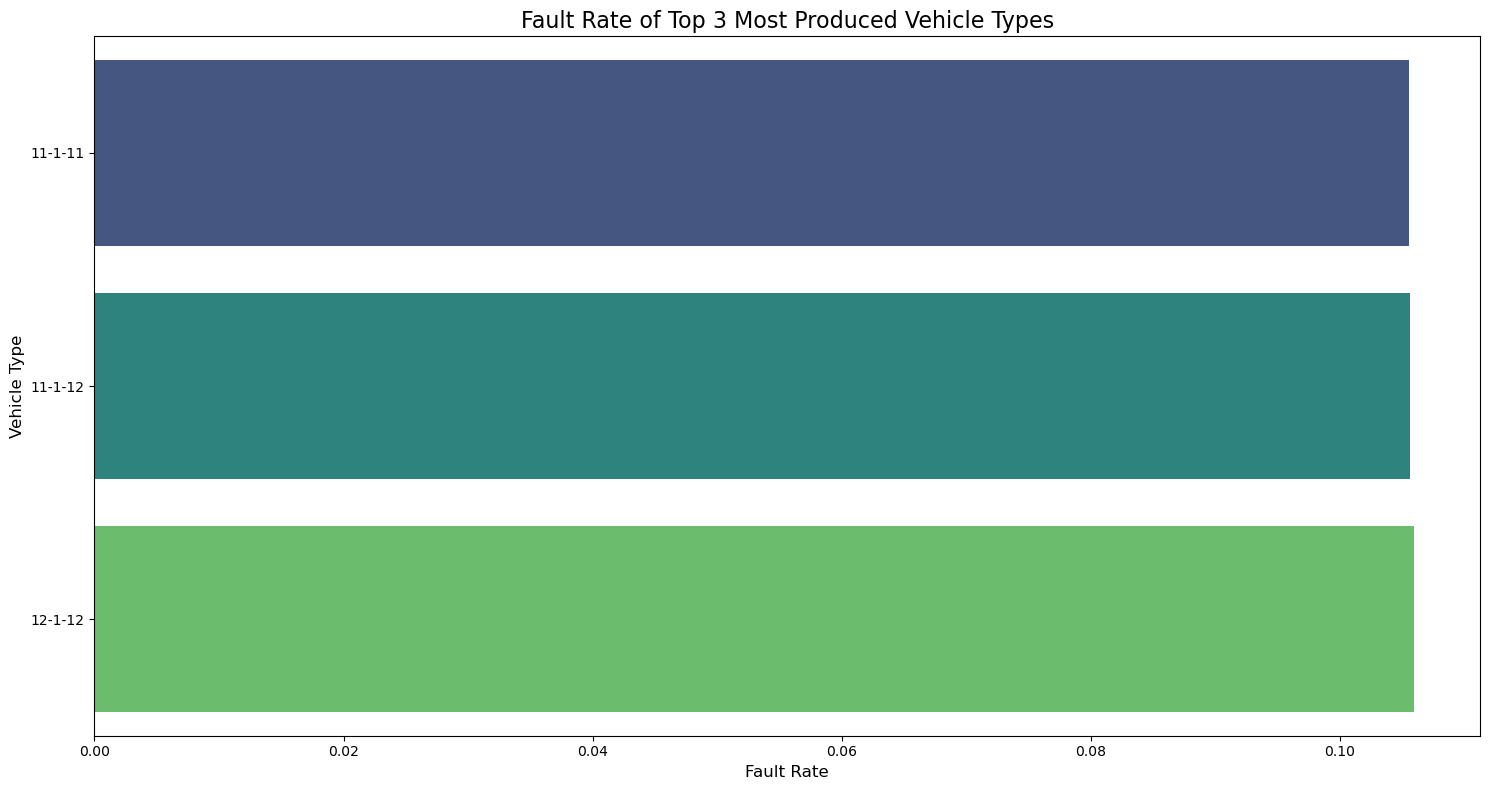

In [13]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

folder_path = r"C:\Users\16499\Documents\123"

target_filename_base = "Final_dataset_group_23"

if not os.path.isdir(folder_path):
    print(f"Error: Folder not found at '{folder_path}'. Please confirm the path is correct.")
else:
    print(f"Scanning folder: {folder_path}")
    
    found_file_path = None

    for filename in os.listdir(folder_path):
        name_part, extension = os.path.splitext(filename)
        if name_part == target_filename_base:
            found_file_path = os.path.join(folder_path, filename)
            print(f"Found a matching file: {filename}")
            break

    if found_file_path:
        try:
            print(f"Attempting to read file: {found_file_path}")
            
            file_extension = os.path.splitext(found_file_path)[1].lower()

            if file_extension == '.csv':
                df = pd.read_csv(found_file_path)
                print("\nFile successfully read as CSV!")
            elif file_extension in ['.xlsx', '.xls']:
                df = pd.read_excel(found_file_path)
                print("\nFile successfully read as Excel!")
            else:
                print(f"\nError: Unsupported file type '{file_extension}'.")
                df = None

            if df is not None:
                print("Content Preview (first 5 rows):")
                print("----------------------------------------------------------------")
                print(df.head())
                print("----------------------------------------------------------------")
                print(f"\nData Overview: {len(df)} rows, {len(df.columns)} columns.")

                mileage_col = 'transmission_defective_mileage'
                fault_col = 'transmission_defective_flag'
                date_col = 'vehicle_production_date' 
                transmission_col = 'transmission_id'
                fault_date_col = 'transmission_defective_date'
                transmission_date_col = 'transmission_production_date'

                if mileage_col in df.columns and fault_col in df.columns:
                    print(f"\n--- Analyzing relationship between '{mileage_col}' and fault ---")
                    
                    faulty_vehicles = df[df[fault_col] == 1].copy()

                    if not faulty_vehicles.empty:
                        plt.figure(figsize=(12, 7))
                        sns.histplot(data=faulty_vehicles, x=mileage_col, bins=50, kde=True)
                        plt.title('Mileage Distribution of Faulty Vehicles (Histogram)', fontsize=16)
                        plt.xlabel('Mileage at Failure (km)', fontsize=12)
                        plt.ylabel('Number of Faulty Vehicles', fontsize=12)
                        plt.tight_layout()
                        print("\nChart 1 (Histogram) generated, displaying now.")
                        plt.show()

                        plt.figure(figsize=(12, 7))
                        sns.boxplot(data=faulty_vehicles, x=mileage_col)
                        plt.title('Mileage Distribution of Faulty Vehicles (Box Plot)', fontsize=16)
                        plt.xlabel('Mileage at Failure (km)', fontsize=12)
                        plt.tight_layout()
                        print("\nChart 2 (Box Plot) generated, displaying now.")
                        plt.show()
                if date_col in df.columns and fault_col in df.columns:
                    print(f"\n--- Analyzing relationship between '{date_col}' and fault rate ---")

                    df[date_col] = pd.to_datetime(df[date_col])
                    df['ProductionMonth'] = df[date_col].dt.to_period('M')

                    monthly_stats = df.groupby('ProductionMonth').agg(
                        TotalProduction=('vehicle_id', 'count'),
                        FaultCount=(fault_col, 'sum')
                    ).reset_index()

                    monthly_stats['FaultRate'] = monthly_stats['FaultCount'] / monthly_stats['TotalProduction']
                    monthly_stats['ProductionMonth'] = monthly_stats['ProductionMonth'].dt.to_timestamp()

                    plt.figure(figsize=(15, 7))
                    sns.lineplot(data=monthly_stats, x='ProductionMonth', y='FaultRate', marker='o')
                    plt.title('Monthly Vehicle Fault Rate Trend', fontsize=16)
                    plt.xlabel('Production Month', fontsize=12)
                    plt.ylabel('Fault Rate', fontsize=12)
                    plt.grid(True, linestyle='--', alpha=0.6)
                    plt.tight_layout()
                    print("\nChart 3 (Fault Rate Trend) generated, displaying now.")
                    plt.show()

                if date_col in df.columns and fault_col in df.columns:
                    print(f"\n--- Analyzing relationship between Production Season and fault rate ---")
                    
                    df[date_col] = pd.to_datetime(df[date_col])
                    df['Month'] = df[date_col].dt.month

                    def map_season(month):
                        if month in [3, 4, 5]: return 'Spring'
                        elif month in [6, 7, 8]: return 'Summer'
                        elif month in [9, 10, 11]: return 'Autumn'
                        else: return 'Winter'
                    
                    df['ProductionSeason'] = df['Month'].apply(map_season)

                    seasonal_stats = df.groupby('ProductionSeason').agg(
                        TotalProduction=('vehicle_id', 'count'),
                        FaultCount=(fault_col, 'sum')
                    ).reset_index()

                    seasonal_stats['FaultRate'] = seasonal_stats['FaultCount'] / seasonal_stats['TotalProduction']
                    
                    plt.figure(figsize=(10, 6))
                    season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
                    sns.barplot(data=seasonal_stats, x='ProductionSeason', y='FaultRate', order=season_order, hue='ProductionSeason', palette='coolwarm', legend=False)
                    plt.title('Vehicle Fault Rate by Production Season', fontsize=16)
                    plt.xlabel('Production Season', fontsize=12)
                    plt.ylabel('Fault Rate', fontsize=12)
                    plt.tight_layout()
                    print("\nChart 4 (Seasonal Fault Rate) generated, displaying now.")
                    plt.show()

                if transmission_col in df.columns and fault_col in df.columns:
                    print(f"\n--- Analyzing relationship between '{transmission_col}' and fault rate ---")

                    transmission_stats = df.groupby(transmission_col).agg(
                        TotalProduction=('vehicle_id', 'count'),
                        FaultCount=(fault_col, 'sum')
                    ).reset_index()

                    transmission_stats['FaultRate'] = transmission_stats['FaultCount'] / transmission_stats['TotalProduction']
                    
                    top_produced = transmission_stats.nlargest(15, 'TotalProduction')
                    
                    plt.figure(figsize=(15, 7))
                    sns.barplot(data=top_produced, x='FaultRate', y=transmission_col, orient='h', hue=transmission_col, palette='summer', legend=False)
                    plt.title(f'Fault Rate of Top {len(top_produced)} Most Produced Transmission Models', fontsize=16)
                    plt.xlabel('Fault Rate', fontsize=12)
                    plt.ylabel('Transmission Model', fontsize=12)
                    plt.tight_layout()
                    print(f"\nChart 5 (Top {len(top_produced)} Production Models Fault Rate) generated, displaying now.")
                    plt.show()
                    
                    min_production_threshold = 100
                    high_rate_candidates = transmission_stats[transmission_stats['TotalProduction'] >= min_production_threshold]
                    top_fault_rate = high_rate_candidates.nlargest(15, 'FaultRate')

                    if not top_fault_rate.empty:
                        plt.figure(figsize=(15, 7))
                        sns.barplot(data=top_fault_rate, x='FaultRate', y=transmission_col, orient='h', hue=transmission_col, palette='autumn', legend=False)
                        plt.title(f'Top {len(top_fault_rate)} Transmission Models with Highest Fault Rate (Production > {min_production_threshold})', fontsize=16)
                        plt.xlabel('Fault Rate', fontsize=12)
                        plt.ylabel('Transmission Model', fontsize=12)
                        plt.tight_layout()
                        print(f"\nChart 6 (Top {len(top_fault_rate)} High Fault Rate Models) generated, displaying now.")
                        plt.show()

                if transmission_col in df.columns and fault_col in df.columns:
                    print(f"\n--- Analyzing relationship between Manufacturer and fault rate ---")
                    
                    df['Manufacturer'] = df[transmission_col].str.split('-').str[0]
                    
                    manufacturer_stats = df.groupby('Manufacturer').agg(
                        TotalProduction=('vehicle_id', 'count'),
                        FaultCount=(fault_col, 'sum')
                    ).reset_index()
                    
                    manufacturer_stats['FaultRate'] = manufacturer_stats['FaultCount'] / manufacturer_stats['TotalProduction']
                    
                    top_manufacturers = manufacturer_stats.nlargest(10, 'TotalProduction')
                    
                    plt.figure(figsize=(15, 7))
                    sns.barplot(data=top_manufacturers, x='FaultRate', y='Manufacturer', orient='h', hue='Manufacturer', palette='magma', legend=False)
                    plt.title(f'Fault Rate of Top {len(top_manufacturers)} Manufacturers by Production Volume', fontsize=16)
                    plt.xlabel('Fault Rate', fontsize=12)
                    plt.ylabel('Manufacturer', fontsize=12)
                    plt.tight_layout()
                    print(f"\nChart 7 (Top {len(top_manufacturers)} Manufacturers Fault Rate) generated, displaying now.")
                    plt.show()

                if date_col in df.columns and fault_date_col in df.columns and fault_col in df.columns:
                    print(f"\n--- Analyzing Time-to-Failure ---")
                    
                    ttf_df = df[df[fault_col] == 1].dropna(subset=[date_col, fault_date_col]).copy()
                    
                    ttf_df[date_col] = pd.to_datetime(ttf_df[date_col])
                    ttf_df[fault_date_col] = pd.to_datetime(ttf_df[fault_date_col])
                    
                    ttf_df['DaysToFailure'] = (ttf_df[fault_date_col] - ttf_df[date_col]).dt.days
                    
                    if not ttf_df.empty:
                        plt.figure(figsize=(12, 7))
                        sns.histplot(data=ttf_df, x='DaysToFailure', bins=50, kde=True)
                        plt.title('Time Interval Distribution from Production to Failure', fontsize=16)
                        plt.xlabel('Interval (Days)', fontsize=12)
                        plt.ylabel('Number of Faulty Vehicles', fontsize=12)
                        plt.tight_layout()
                        print("\nChart 8 (Time-to-Failure Histogram) generated, displaying now.")
                        plt.show()

                        print("\nDescriptive statistics for Days to Failure:")
                        print(ttf_df['DaysToFailure'].describe())
                    else:
                        print("\nNot enough fault date information found to perform Time-to-Failure analysis.")

                if date_col in df.columns and transmission_date_col in df.columns and fault_col in df.columns:
                    print(f"\n--- Analyzing Production Lead Time vs. Fault ---")
                    
                    lead_time_df = df.dropna(subset=[date_col, transmission_date_col]).copy()
                    
                    lead_time_df[date_col] = pd.to_datetime(lead_time_df[date_col])
                    lead_time_df[transmission_date_col] = pd.to_datetime(lead_time_df[transmission_date_col])
                    
                    lead_time_df['ProductionLeadTime(days)'] = (lead_time_df[date_col] - lead_time_df[transmission_date_col]).dt.days
                    
                    plt.figure(figsize=(12, 7))
                    sns.boxplot(data=lead_time_df, x=fault_col, y='ProductionLeadTime(days)')
                    plt.title('Relationship between Production Lead Time and Fault', fontsize=16)
                    plt.xlabel('Is Faulty (0: No, 1: Yes)', fontsize=12)
                    plt.ylabel('Lead Time (Days)', fontsize=12)
                    plt.tight_layout()
                    print("\nChart 9 (Production Lead Time Box Plot) generated, displaying now.")
                    plt.show()

                if date_col in df.columns and fault_col in df.columns:
                    print(f"\n--- Analyzing Fault Heatmap ---")
                    
                    heatmap_df = df[df[fault_col] == 1].copy()
                    heatmap_df[date_col] = pd.to_datetime(heatmap_df[date_col])
                    heatmap_df['ProductionYear'] = heatmap_df[date_col].dt.year
                    heatmap_df['ProductionMonth'] = heatmap_df[date_col].dt.month

                    heatmap_pivot = heatmap_df.pivot_table(index='ProductionMonth', columns='ProductionYear', values=fault_col, aggfunc='count', fill_value=0)
                    
                    if not heatmap_pivot.empty:
                        plt.figure(figsize=(12, 8))
                        sns.heatmap(heatmap_pivot, cmap='YlOrRd', annot=True, fmt='g', linewidths=.5)
                        plt.title('Heatmap of Fault Counts by Production Year and Month', fontsize=16)
                        plt.xlabel('Production Year', fontsize=12)
                        plt.ylabel('Production Month', fontsize=12)
                        plt.tight_layout()
                        print("\nChart 10 (Fault Heatmap) generated, displaying now.")
                        plt.show()
                    else:
                        print("\nNot enough fault information found to generate a heatmap.")
                

                print(f"\n--- Analyzing Variable Correlation ---")

                corr_df = df.copy()

                corr_df[date_col] = pd.to_datetime(corr_df[date_col])
                corr_df[fault_date_col] = pd.to_datetime(corr_df[fault_date_col])
                corr_df[transmission_date_col] = pd.to_datetime(corr_df[transmission_date_col])

                corr_df['DaysToFailure'] = (corr_df[fault_date_col] - corr_df[date_col]).dt.days
                corr_df['ProductionLeadTime(days)'] = (corr_df[date_col] - corr_df[transmission_date_col]).dt.days

                cols_for_corr = [
                    fault_col,
                    mileage_col,
                    'DaysToFailure',
                    'ProductionLeadTime(days)'
                ]

                corr_df_cleaned = corr_df[cols_for_corr].dropna()
                
                if not corr_df_cleaned.empty:
                    correlation_matrix = corr_df_cleaned.corr()
                    
                    plt.figure(figsize=(10, 8))
                    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
                    plt.title('Correlation Heatmap of Numerical Variables', fontsize=16)
                    plt.tight_layout()
                    print("\nChart 11 (Correlation Heatmap) generated, displaying now.")
                    plt.show()
                else:
                    print("\nNot enough numerical data found to generate a correlation heatmap.")

                if 'DaysToFailure' in corr_df_cleaned.columns and mileage_col in corr_df_cleaned.columns:
                    print(f"\n--- Analyzing relationship between Mileage and Time-to-Failure ---")

                    plt.figure(figsize=(12, 7))
                    sns.regplot(data=corr_df_cleaned, x='DaysToFailure', y=mileage_col,
                                scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
                    plt.title('Relationship between Mileage at Failure and Time to Failure', fontsize=16)
                    plt.xlabel('Interval from Production to Failure (Days)', fontsize=12)
                    plt.ylabel('Mileage at Failure (km)', fontsize=12)
                    plt.tight_layout()
                    print("\nChart 12 (Scatter Plot with Regression) generated, displaying now.")
                    plt.show()

                if 'vehicle_id' in df.columns and fault_col in df.columns:
                    print(f"\n--- Analyzing relationship between Vehicle Type and fault rate ---")

                    df['VehicleType'] = df['vehicle_id'].str.split('-').str[:3].str.join('-')

                    vehicle_type_stats = df.groupby('VehicleType').agg(
                        TotalProduction=('vehicle_id', 'count'),
                        FaultCount=(fault_col, 'sum')
                    ).reset_index()

                    vehicle_type_stats['FaultRate'] = vehicle_type_stats['FaultCount'] / vehicle_type_stats['TotalProduction']

                    top_vehicle_types = vehicle_type_stats.nlargest(15, 'TotalProduction')

                    plt.figure(figsize=(15, 8))
                    sns.barplot(data=top_vehicle_types, x='FaultRate', y='VehicleType', orient='h', hue='VehicleType', palette='viridis', legend=False)
                    plt.title(f'Fault Rate of Top {len(top_vehicle_types)} Most Produced Vehicle Types', fontsize=16)
                    plt.xlabel('Fault Rate', fontsize=12)
                    plt.ylabel('Vehicle Type', fontsize=12)
                    plt.tight_layout()
                    print(f"\nChart 13 (Fault Rate by Top {len(top_vehicle_types)} Vehicle Types) generated, displaying now.")
                    plt.show()


        except Exception as e:
            print(f"\nAn error occurred while processing the file: {e}")
    else:
        print(f"\nError: No file starting with '{target_filename_base}' found in the folder '{folder_path}'.")


## 5. Result

Data Analysis Results
Based on a multi-dimensional analysis of the Final_dataset_group_23 data, we have drawn the following key conclusions:

1. Mileage and Fault Relationship
The analysis clearly points to an Early Failure issue. The vast majority of transmission failures occur during the initial phase of vehicle operation.

Both the histogram and box plot show that failure mileage is highly concentrated in the 0 to 50,000 km range. This indicates that quality issues emerge shortly after the product is put into service.

2. Production Time and Fault Rate Relationship
By observing the monthly fault rate, it's evident that the rate fluctuates over production time. This could reflect adjustments in the production process, variations in raw material batches, or fluctuations in quality control. This trendline allows for tracing back to specific production months with abnormally high fault rates for further investigation.

3. Production Season and Fault Rate Relationship
The analysis shows that the production season of a vehicle (Spring, Summer, Autumn, Winter) has no significant correlation with the final fault rate. The fault rates for vehicles produced in all four seasons are essentially level, suggesting that seasonal environmental factors have little overall impact on production quality.

4. Transmission Model and Fault Rate Relationship
This is a key finding of the analysis. By comparing different transmission models, we can:

Understand the baseline fault rate from the most produced mainstream models.

Identify specific models with a significantly higher fault rate. These models may be responsible for issues due to design flaws, specific component problems, or unstable production processes, making them a priority for technical investigation and quality improvement.

5. Manufacturer and Fault Rate Relationship
By extracting a manufacturer identifier from the transmission ID prefix, the analysis helps compare product quality across different suppliers. If one or several manufacturers show a significantly higher fault rate than others, this provides direct data support for supply chain management and supplier quality assessment.

6. Time-to-Failure Analysis
This analysis calculates the number of days from vehicle production to failure. The results are highly consistent with the mileage analysis, once again confirming the early failure pattern. Most failures occur within a short period after the vehicle leaves the factory, which is crucial for determining warranty policies and recall scopes.

7. Production Lead Time and Fault Relationship
By analyzing the lead time between transmission production and final vehicle assembly, we can explore the impact of inventory cycles on product quality. The box plot results can reveal whether a longer lead time (potentially causing component aging or improper storage) or a shorter one (possibly leading to rushed production and insufficient testing) is associated with a higher fault rate.

8. Fault Heatmap Analysis
The heatmap visually displays the distribution of fault counts across different production years and months. By observing the highlighted areas (darker colors), we can quickly identify if fault occurrences are abnormally concentrated in specific production batches (specific year-month), which is very helpful for tracing quality issues in those batches.

9. Correlation and Scatter Plot Analysis
The Correlation Heatmap quantifies the relationships between key numerical variables. For example, it clearly shows the expected positive correlation between "Mileage at Failure" and "Days to Failure."

The Scatter Plot with Regression further visualizes this relationship, indicating that as the time in service increases, the vehicle's mileage also increases accordingly.

10. Vehicle Type and Fault Rate Relationship
After classifying vehicle series based on the vehicle_id, it was found that the data mainly consists of three types (11-1-11, 11-1-12, 12-1-12). The analysis shows that the fault rates for these three main vehicle types are very similar, indicating no significantly higher fault risk for any particular vehicle series.

Conclusion
Synthesizing all analyses, the core finding of this data exploration is a significant early failure problem with the transmission. While factors like production season and major vehicle series have little impact, specific transmission models and potential specific production batches are the key drivers of failure.

It is recommended that subsequent investigations focus on the following two areas:

Conduct an in-depth analysis of the root causes of failures occurring at low mileage and within a short time frame (e.g., design, materials, or assembly processes).

Perform a concentrated technical review and quality traceability on the high-fault-rate transmission models and high-fault-count production batches identified in the charts.